# Capstone

This notebook is used for Coursera Capstone project.

In [401]:
import pandas as pd
import numpy as np

## Data acquisition and cleaning
Read initial data from CSV

In [402]:
df = pd.read_csv("../Data-Collisions.csv")

/Users/strakh/Development/merapar/jupiterlab/env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [403]:
df.head()

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


In [404]:
df.columns

Index(['SEVERITYCODE', 'X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO',
       'STATUS', 'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE',
       'EXCEPTRSNDESC', 'SEVERITYCODE.1', 'SEVERITYDESC', 'COLLISIONTYPE',
       'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INCDATE',
       'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC',
       'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND',
       'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE', 'ST_COLDESC',
       'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR'],
      dtype='object')

In [405]:
df.shape

(194673, 38)

In [406]:
df.dtypes


SEVERITYCODE        int64
X                 float64
Y                 float64
OBJECTID            int64
INCKEY              int64
COLDETKEY           int64
REPORTNO           object
STATUS             object
ADDRTYPE           object
INTKEY            float64
LOCATION           object
EXCEPTRSNCODE      object
EXCEPTRSNDESC      object
SEVERITYCODE.1      int64
SEVERITYDESC       object
COLLISIONTYPE      object
PERSONCOUNT         int64
PEDCOUNT            int64
PEDCYLCOUNT         int64
VEHCOUNT            int64
INCDATE            object
INCDTTM            object
JUNCTIONTYPE       object
SDOT_COLCODE        int64
SDOT_COLDESC       object
INATTENTIONIND     object
UNDERINFL          object
WEATHER            object
ROADCOND           object
LIGHTCOND          object
PEDROWNOTGRNT      object
SDOTCOLNUM        float64
SPEEDING           object
ST_COLCODE         object
ST_COLDESC         object
SEGLANEKEY          int64
CROSSWALKKEY        int64
HITPARKEDCAR       object
dtype: objec

Select meaningful features, irrelevant data like internal identifiers and text comments are excluded

In [407]:
features = ['SEVERITYCODE', 'STATUS', 'ADDRTYPE', 'PERSONCOUNT', 'JUNCTIONTYPE', 'SPEEDING', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'UNDERINFL']

In [408]:
X = df[features]

In [409]:
X.shape

(194673, 10)

Look at particular fields and drop data that is considered not useful

In [410]:
X[['STATUS']].value_counts()

STATUS   
Matched      189786
Unmatched      4887
dtype: int64

There is a small subset of accidents that marked as "unmatched". It's hard to say what does actually mean but it seems like data that may introduce noise. It's safer to just drop it and then the column itself.

In [411]:
X = X.loc[X['STATUS'] == 'Matched']
X[['STATUS']].value_counts()

STATUS 
Matched    189786
dtype: int64

In [412]:
X.shape

(189786, 10)

In [413]:
X = X.drop('STATUS', axis=1)
X.shape

(189786, 9)

In [414]:
X[['JUNCTIONTYPE']].value_counts()

JUNCTIONTYPE                                     
Mid-Block (not related to intersection)              87119
At Intersection (intersection related)               61334
Mid-Block (but intersection related)                 22388
Driveway Junction                                    10538
At Intersection (but not related to intersection)     2060
Ramp Junction                                          162
Unknown                                                  7
dtype: int64

Values like `Unknown` or `Other` are essentially the same as no value at all. They do not bring any value to the dataset.
So it's fair to drop records with incomplete data.

In [415]:
X = X.loc[X['JUNCTIONTYPE'] != 'Unknown']

In [416]:
X.shape

(189779, 9)

In [417]:
for field in ('SPEEDING',):
    print(X[[field]].value_counts())
    X[[field]] = X[[field]].fillna(0).replace('Y', 1)
    print(X[[field]].value_counts())

SPEEDING
Y           9332
dtype: int64
SPEEDING
0           180447
1             9332
dtype: int64


In [418]:
for field in ('WEATHER', 'ROADCOND', 'LIGHTCOND'):
    print(X[[field]].value_counts())
    X = X.loc[~X[field].isin(('Unknown', 'Other'))]
    print(X[[field]].value_counts())

WEATHER                 
Clear                       111129
Raining                      33144
Overcast                     27712
Unknown                      15090
Snowing                        907
Other                          832
Fog/Smog/Smoke                 569
Sleet/Hail/Freezing Rain       113
Blowing Sand/Dirt               56
Severe Crosswind                25
Partly Cloudy                    5
dtype: int64
WEATHER                 
Clear                       111129
Raining                      33144
Overcast                     27712
Snowing                        907
Fog/Smog/Smoke                 569
Sleet/Hail/Freezing Rain       113
Blowing Sand/Dirt               56
Severe Crosswind                25
Partly Cloudy                    5
dtype: int64
ROADCOND      
Dry               123473
Wet                46978
Ice                 1116
Unknown              929
Snow/Slush           904
Standing Water       108
Other                108
Sand/Mud/Dirt         66
Oil      

In [419]:
X.shape

(170323, 9)

For some reason `Dark` value of `LIGHTCOND` has 4 different variants. Aggregate them all to just `Dark` conditions. We are no interested in the reason why it was actually dark when accident occured.

In [420]:
X[['LIGHTCOND']] = X[['LIGHTCOND']].replace(r"^Dark.+", "Dark", regex=True)
X[['LIGHTCOND']].value_counts()

LIGHTCOND
Daylight     112668
Dark          49348
Dusk           5660
Dawn           2412
dtype: int64

In [421]:
X[['UNDERINFL']].value_counts()

UNDERINFL
N            89822
0            71499
Y             5060
1             3942
dtype: int64

This column show inconsistency in its values, easy to fix.

In [422]:
X[['UNDERINFL']] = X[['UNDERINFL']].replace(('N', 'Y'), (0,1)).astype('int')
print(X[['UNDERINFL']].value_counts())
X = X.loc[X['UNDERINFL'] == 0]
X.drop('UNDERINFL', axis=1, inplace=True)
X.shape

UNDERINFL
0            161321
1              9002
dtype: int64


(161321, 8)

In [423]:
X.dtypes

SEVERITYCODE     int64
ADDRTYPE        object
PERSONCOUNT      int64
JUNCTIONTYPE    object
SPEEDING         int64
WEATHER         object
ROADCOND        object
LIGHTCOND       object
dtype: object

In [424]:
X.head()

,SEVERITYCODE,ADDRTYPE,PERSONCOUNT,JUNCTIONTYPE,SPEEDING,WEATHER,ROADCOND,LIGHTCOND
0,2,Intersection,2,At Intersection (intersection related),0,Overcast,Wet,Daylight
1,1,Block,2,Mid-Block (not related to intersection),0,Raining,Wet,Dark
2,1,Block,4,Mid-Block (not related to intersection),0,Overcast,Dry,Daylight
3,1,Block,3,Mid-Block (not related to intersection),0,Clear,Dry,Daylight
4,2,Intersection,2,At Intersection (intersection related),0,Raining,Wet,Daylight


Save current dataset for later visualisation

In [425]:
vizX = pd.DataFrame(X)

Perform one-hot encondig of categorical columns

In [426]:
for field in 'ADDRTYPE', 'JUNCTIONTYPE', 'WEATHER', 'ROADCOND', 'LIGHTCOND':
    X = pd.concat([X,pd.get_dummies(X[field], field)], axis=1)
    X.drop(field, axis=1, inplace=True)
    print(X.columns)

Index(['SEVERITYCODE', 'PERSONCOUNT', 'JUNCTIONTYPE', 'SPEEDING', 'WEATHER',
       'ROADCOND', 'LIGHTCOND', 'ADDRTYPE_Alley', 'ADDRTYPE_Block',
       'ADDRTYPE_Intersection'],
      dtype='object')
Index(['SEVERITYCODE', 'PERSONCOUNT', 'SPEEDING', 'WEATHER', 'ROADCOND',
       'LIGHTCOND', 'ADDRTYPE_Alley', 'ADDRTYPE_Block',
       'ADDRTYPE_Intersection',
       'JUNCTIONTYPE_At Intersection (but not related to intersection)',
       'JUNCTIONTYPE_At Intersection (intersection related)',
       'JUNCTIONTYPE_Driveway Junction',
       'JUNCTIONTYPE_Mid-Block (but intersection related)',
       'JUNCTIONTYPE_Mid-Block (not related to intersection)',
       'JUNCTIONTYPE_Ramp Junction'],
      dtype='object')
Index(['SEVERITYCODE', 'PERSONCOUNT', 'SPEEDING', 'ROADCOND', 'LIGHTCOND',
       'ADDRTYPE_Alley', 'ADDRTYPE_Block', 'ADDRTYPE_Intersection',
       'JUNCTIONTYPE_At Intersection (but not related to intersection)',
       'JUNCTIONTYPE_At Intersection (intersection related)',
  

In [427]:
X.shape

(161321, 32)

In [428]:
X.head()

,SEVERITYCODE,PERSONCOUNT,SPEEDING,ADDRTYPE_Alley,ADDRTYPE_Block,ADDRTYPE_Intersection,JUNCTIONTYPE_At Intersection (but not related to intersection),JUNCTIONTYPE_At Intersection (intersection related),JUNCTIONTYPE_Driveway Junction,JUNCTIONTYPE_Mid-Block (but intersection related),...,ROADCOND_Ice,ROADCOND_Oil,ROADCOND_Sand/Mud/Dirt,ROADCOND_Snow/Slush,ROADCOND_Standing Water,ROADCOND_Wet,LIGHTCOND_Dark,LIGHTCOND_Dawn,LIGHTCOND_Daylight,LIGHTCOND_Dusk
0,2,2,0,0,0,1,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
1,1,2,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
2,1,4,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1,3,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,2,2,0,0,0,1,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0


In [429]:
X.describe()

,SEVERITYCODE,PERSONCOUNT,SPEEDING,ADDRTYPE_Alley,ADDRTYPE_Block,ADDRTYPE_Intersection,JUNCTIONTYPE_At Intersection (but not related to intersection),JUNCTIONTYPE_At Intersection (intersection related),JUNCTIONTYPE_Driveway Junction,JUNCTIONTYPE_Mid-Block (but intersection related),...,ROADCOND_Ice,ROADCOND_Oil,ROADCOND_Sand/Mud/Dirt,ROADCOND_Snow/Slush,ROADCOND_Standing Water,ROADCOND_Wet,LIGHTCOND_Dark,LIGHTCOND_Dawn,LIGHTCOND_Daylight,LIGHTCOND_Dusk
count,161321.000000,161321.000000,161321.000000,161321.000000,161321.000000,161321.000000,161321.000000,161321.000000,161321.000000,161321.000000,...,161321.000000,161321.000000,161321.000000,161321.000000,161321.000000,161321.000000,161321.000000,161321.000000,161321.000000,161321.000000
mean,1.323994,2.500177,0.048754,0.003447,0.625666,0.366660,0.010408,0.355757,0.060253,0.123815,...,0.006515,0.000372,0.000372,0.004909,0.000614,0.271254,0.263927,0.014499,0.686724,0.033461
std,0.467999,1.409160,0.215353,0.058606,0.483952,0.481894,0.101487,0.478743,0.237955,0.329372,...,0.080452,0.019282,0.019282,0.069896,0.024765,0.444608,0.440762,0.119536,0.463827,0.179838
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,2.000000,3.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000
max,2.000000,81.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [430]:
X.dtypes

SEVERITYCODE                                                      int64
PERSONCOUNT                                                       int64
SPEEDING                                                          int64
ADDRTYPE_Alley                                                    uint8
ADDRTYPE_Block                                                    uint8
ADDRTYPE_Intersection                                             uint8
JUNCTIONTYPE_At Intersection (but not related to intersection)    uint8
JUNCTIONTYPE_At Intersection (intersection related)               uint8
JUNCTIONTYPE_Driveway Junction                                    uint8
JUNCTIONTYPE_Mid-Block (but intersection related)                 uint8
JUNCTIONTYPE_Mid-Block (not related to intersection)              uint8
JUNCTIONTYPE_Ramp Junction                                        uint8
WEATHER_Blowing Sand/Dirt                                         uint8
WEATHER_Clear                                                   

extract target variable from features

In [431]:
y = X[['SEVERITYCODE']]
X.drop('SEVERITYCODE', axis=1, inplace=True)
y.value_counts()

SEVERITYCODE
1               109054
2                52267
dtype: int64

since we have only values `1` and `2` in SEVERITYCODE columns, it makes sence to convert it to boolean-like `0` and `1`

In [432]:
y = y - 1
y.value_counts()

SEVERITYCODE
0               109054
1                52267
dtype: int64

Now let's see if there are any highly correlated columns, those might be excluded to reduce number of features withour influence to end result.

In [433]:
c = X.corr()
c.head()

,PERSONCOUNT,SPEEDING,ADDRTYPE_Alley,ADDRTYPE_Block,ADDRTYPE_Intersection,JUNCTIONTYPE_At Intersection (but not related to intersection),JUNCTIONTYPE_At Intersection (intersection related),JUNCTIONTYPE_Driveway Junction,JUNCTIONTYPE_Mid-Block (but intersection related),JUNCTIONTYPE_Mid-Block (not related to intersection),...,ROADCOND_Ice,ROADCOND_Oil,ROADCOND_Sand/Mud/Dirt,ROADCOND_Snow/Slush,ROADCOND_Standing Water,ROADCOND_Wet,LIGHTCOND_Dark,LIGHTCOND_Dawn,LIGHTCOND_Daylight,LIGHTCOND_Dusk
PERSONCOUNT,1.000000,-0.009803,-0.023201,-0.046960,0.052238,0.000832,0.052718,-0.002324,0.036988,-0.062967,...,-0.016168,-0.005021,-0.007759,-0.001393,-0.009329,0.002738,-0.011138,-0.024395,0.014975,0.005749
SPEEDING,-0.009803,1.000000,0.000930,0.071204,-0.072203,0.003160,-0.073234,-0.029986,0.042664,0.057488,...,0.096158,0.000112,0.009069,0.059050,0.036233,0.113659,0.072765,0.014921,-0.071063,-0.003869
ADDRTYPE_Alley,-0.023201,0.000930,1.000000,-0.076030,-0.044746,-0.006031,-0.043701,0.003778,-0.022107,-0.024176,...,-0.000818,-0.001134,0.020808,-0.001104,-0.001457,-0.008759,0.010140,-0.001824,-0.009080,-0.000944
ADDRTYPE_Block,-0.046960,0.071204,-0.076030,1.000000,-0.983682,-0.132585,-0.960604,0.193543,0.290497,0.671049,...,0.033184,0.006949,0.002963,0.019512,0.007789,-0.022313,0.019791,-0.001439,-0.018229,-0.002802
ADDRTYPE_Intersection,0.052238,-0.072203,-0.044746,-0.983682,1.000000,0.134784,0.976191,-0.192662,-0.285985,-0.666173,...,-0.033794,-0.006671,-0.006004,-0.019397,-0.008466,0.023762,-0.020292,0.001763,0.019033,0.001843


In [434]:
c = c.abs().unstack().sort_values(ascending=False).drop_duplicates()
c = c.loc[(c > 0.9) & (c != 1.0)]
c

ADDRTYPE_Block                                       ADDRTYPE_Intersection    0.983682
JUNCTIONTYPE_At Intersection (intersection related)  ADDRTYPE_Intersection    0.976191
ROADCOND_Wet                                         ROADCOND_Dry             0.967011
JUNCTIONTYPE_At Intersection (intersection related)  ADDRTYPE_Block           0.960604
dtype: float64

These pairs of columnt are highly correlated, drop 1 from each pair.

In [435]:
to_drop = {item[0] for item in c.index}
print(to_drop)
for field in to_drop:
    X.drop(field, axis=1, inplace=True)


{'ROADCOND_Wet', 'JUNCTIONTYPE_At Intersection (intersection related)', 'ADDRTYPE_Block'}


In [436]:
print(X.shape)
y = y.values.ravel()
print(y.shape)

(161321, 28)
(161321,)


In [437]:
X_columns = X.columns
X_columns

Index(['PERSONCOUNT', 'SPEEDING', 'ADDRTYPE_Alley', 'ADDRTYPE_Intersection',
       'JUNCTIONTYPE_At Intersection (but not related to intersection)',
       'JUNCTIONTYPE_Driveway Junction',
       'JUNCTIONTYPE_Mid-Block (but intersection related)',
       'JUNCTIONTYPE_Mid-Block (not related to intersection)',
       'JUNCTIONTYPE_Ramp Junction', 'WEATHER_Blowing Sand/Dirt',
       'WEATHER_Clear', 'WEATHER_Fog/Smog/Smoke', 'WEATHER_Overcast',
       'WEATHER_Partly Cloudy', 'WEATHER_Raining', 'WEATHER_Severe Crosswind',
       'WEATHER_Sleet/Hail/Freezing Rain', 'WEATHER_Snowing', 'ROADCOND_Dry',
       'ROADCOND_Ice', 'ROADCOND_Oil', 'ROADCOND_Sand/Mud/Dirt',
       'ROADCOND_Snow/Slush', 'ROADCOND_Standing Water', 'LIGHTCOND_Dark',
       'LIGHTCOND_Dawn', 'LIGHTCOND_Daylight', 'LIGHTCOND_Dusk'],
      dtype='object')

This is the end of data cleaning and transformation section. At this point we consider it ready for Modeling step.

# Exploratory Analysis

In [438]:
vizX['SEVERITYCODE'] = y
vizX.head()

,SEVERITYCODE,ADDRTYPE,PERSONCOUNT,JUNCTIONTYPE,SPEEDING,WEATHER,ROADCOND,LIGHTCOND
0,1,Intersection,2,At Intersection (intersection related),0,Overcast,Wet,Daylight
1,0,Block,2,Mid-Block (not related to intersection),0,Raining,Wet,Dark
2,0,Block,4,Mid-Block (not related to intersection),0,Overcast,Dry,Daylight
3,0,Block,3,Mid-Block (not related to intersection),0,Clear,Dry,Daylight
4,1,Intersection,2,At Intersection (intersection related),0,Raining,Wet,Daylight


In [439]:
vizX.columns

Index(['SEVERITYCODE', 'ADDRTYPE', 'PERSONCOUNT', 'JUNCTIONTYPE', 'SPEEDING',
       'WEATHER', 'ROADCOND', 'LIGHTCOND'],
      dtype='object')

Iterate over columns and visualize total and severe accidents

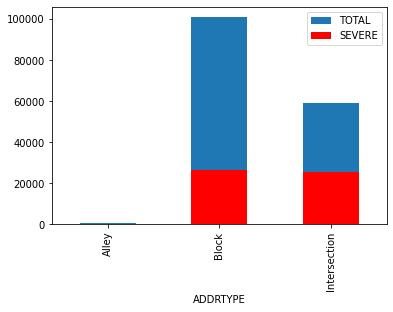

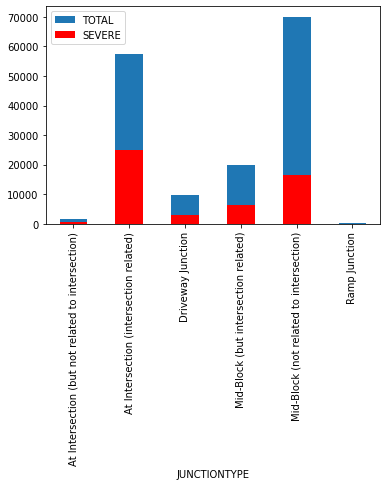

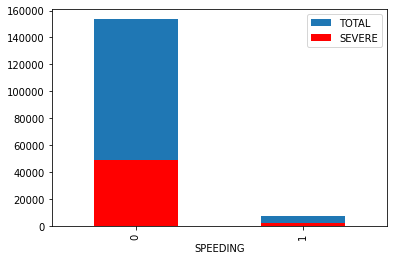

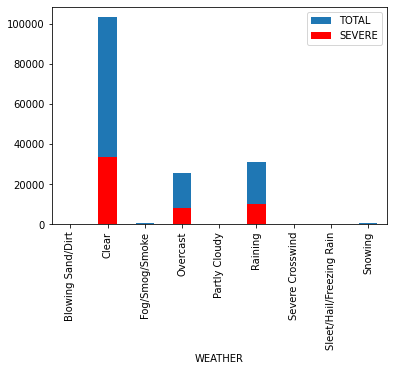

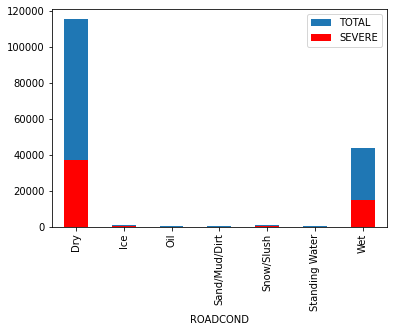

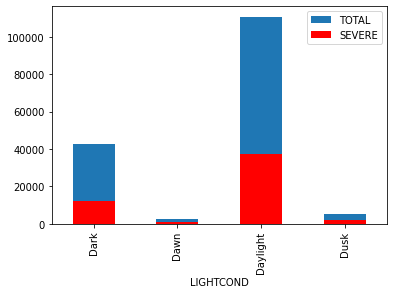

In [454]:
for field in ['ADDRTYPE', 'JUNCTIONTYPE', 'SPEEDING', 'WEATHER', 'ROADCOND', 'LIGHTCOND']:
    total = vizX.groupby(field).count()[["SEVERITYCODE"]]
    total.columns = ["TOTAL"]
    a = total.plot.bar()
    severe = vizX.groupby(field).sum()[["SEVERITYCODE"]]
    severe.columns = ["SEVERE"]
    severe.plot.bar(ax =a, color='red')
    plt.savefig(f"explore_{field}.png", bbox_inches = 'tight')

PERSONCOUNT need some more attention

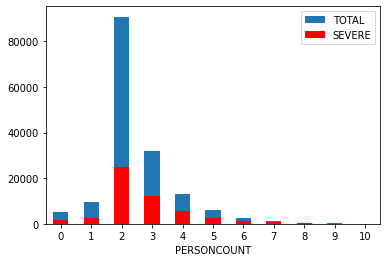

In [441]:
field = 'PERSONCOUNT'
total = vizX.loc[vizX[field] <= 10].groupby(field).count()[["SEVERITYCODE"]]
total.columns = ["TOTAL"]
a = total.plot.bar()
severe = vizX.loc[vizX[field] <= 10].groupby(field).sum()[["SEVERITYCODE"]]
severe.columns = ["SEVERE"]
b= severe.plot.bar(ax=a, color='red')
plt.xticks(total.index, rotation='horizontal')
plt.savefig(f"explore_{field}.png")

# Modeling
## Rescale features
use StandardScaler to transform X

In [442]:
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))

## Split dataset to train and test
It tuned out that our dataset is a bit too large for the purpose of searching right metaparameters, some algorithms are quicker than others, but in general it took too much time.
So once models' proper metaparameter are found we resplit inital dataset to train/test and use it.

In [443]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=1)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

print("number of test samples :", X_test.shape[0])
print("number of training samples:",X_train.shape[0])

number of test samples : 3227
number of training samples: 12905


Here is some helper code for modeling results storage.

In [444]:
results = {}
class Result:
    def __init__(self, confusion, accuracy, f1, logloss=None):
        self.confusion = confusion
        self.accuracy = accuracy
        self.f1 = f1
        self.logloss = logloss

## Find Metaparameters

### Decision Tree
We search for optimal tree depth there. Starting from `depth=3` since trivial result of `0` for all the cases isn't what we hope for.

In [445]:
from sklearn.tree import DecisionTreeClassifier
d_min = 3
d_max = 30
dtree_scores = np.zeros((d_max-1))
from sklearn import metrics
for depth in range(d_min, d_max):
    dtree = DecisionTreeClassifier(criterion="entropy", max_depth = depth, class_weight="balanced").fit(X_train, y_train)
    dtree_scores[depth-d_min] = metrics.f1_score(y_test, dtree.predict(X_test), average='weighted')
    print(f"DecisionTrees's score (depth={depth}): {dtree_scores[depth-d_min]}")
print(f"The best score is {dtree_scores.max()} with depth={dtree_scores.argmax()+d_min}") 

DecisionTrees's score (depth=3): 0.5842421945817393
DecisionTrees's score (depth=4): 0.5845634692552406
DecisionTrees's score (depth=5): 0.6019862609922358
DecisionTrees's score (depth=6): 0.5863805346932885
DecisionTrees's score (depth=7): 0.6003519911448917
DecisionTrees's score (depth=8): 0.6033868111577709
DecisionTrees's score (depth=9): 0.6017601018272398
DecisionTrees's score (depth=10): 0.6046102654164847
DecisionTrees's score (depth=11): 0.594737624976762
DecisionTrees's score (depth=12): 0.5859541193635821
DecisionTrees's score (depth=13): 0.5862123122596437
DecisionTrees's score (depth=14): 0.5916456879069522
DecisionTrees's score (depth=15): 0.5917654412191423
DecisionTrees's score (depth=16): 0.5895928623791534
DecisionTrees's score (depth=17): 0.5917841441223194
DecisionTrees's score (depth=18): 0.5907753642936798
DecisionTrees's score (depth=19): 0.591707453002538
DecisionTrees's score (depth=20): 0.5916672291637312
DecisionTrees's score (depth=21): 0.5913562832934395
De

### Random Forest
More advanced decision tree approach, since it usually gives less deep trees

In [448]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
d_min = 3
d_max = 30
rfc_scores = np.zeros((d_max-1))
for depth in range(d_min, d_max):
    rfc = RandomForestClassifier(criterion="entropy", max_depth=depth, random_state=0, class_weight="balanced").fit(X_train, y_train)
    rfc_scores[depth-d_min] = metrics.f1_score(y_test, rfc.predict(X_test), average='weighted')
    print(f"RandomForest's score (depth={depth}): {rfc_scores[depth-d_min]}")
print(f"The best score is {rfc_scores.max()} with depth={rfc_scores.argmax()+d_min}") 

RandomForest's score (depth=3): 0.6314587959358231
RandomForest's score (depth=4): 0.6308990739819185
RandomForest's score (depth=5): 0.6195841028377765
RandomForest's score (depth=6): 0.6083353054892549
RandomForest's score (depth=7): 0.6083239989138935
RandomForest's score (depth=8): 0.6198609955616171
RandomForest's score (depth=9): 0.6078742508704246
RandomForest's score (depth=10): 0.6088000807939187
RandomForest's score (depth=11): 0.6061203642522593
RandomForest's score (depth=12): 0.5977417938056963
RandomForest's score (depth=13): 0.5977142115284323
RandomForest's score (depth=14): 0.5983008502131568
RandomForest's score (depth=15): 0.5977142115284323
RandomForest's score (depth=16): 0.5977808328064934
RandomForest's score (depth=17): 0.5972045618487213
RandomForest's score (depth=18): 0.5981231892213367
RandomForest's score (depth=19): 0.5990185095202715
RandomForest's score (depth=20): 0.5977932226897477
RandomForest's score (depth=21): 0.5980874497872658
RandomForest's scor

### Gradient Boost

In [224]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
d_min = 3
d_max = 30
gbc_scores = np.zeros((d_max-1))
for depth in range(d_min, d_max):
    gbc = GradientBoostingClassifier(max_depth=depth, random_state=0).fit(X_train, y_train)
    gbc_scores[depth-d_min] = metrics.f1_score(y_test, gbc.predict(X_test), average='weighted')
    print(f"GradientBoosting's score (depth={depth}): {gbc_scores[depth-d_min]}")
print(f"The best score is {gbc_scores.max()} with depth={gbc_scores.argmax()+d_min}") 

GradientBoosting's score (depth=3): 0.5794272124317921
GradientBoosting's score (depth=4): 0.5893882198313757
GradientBoosting's score (depth=5): 0.5889572844584416
GradientBoosting's score (depth=6): 0.5897764999649266
GradientBoosting's score (depth=7): 0.5922625049462876
GradientBoosting's score (depth=8): 0.5921997918496333
GradientBoosting's score (depth=9): 0.5945879751175086
GradientBoosting's score (depth=10): 0.5970381441878168
GradientBoosting's score (depth=11): 0.5965828098149141
GradientBoosting's score (depth=12): 0.5980769475563402
GradientBoosting's score (depth=13): 0.5990332316813741
GradientBoosting's score (depth=14): 0.5976049948375644
GradientBoosting's score (depth=15): 0.5999167495292483
GradientBoosting's score (depth=16): 0.5979447269396814
GradientBoosting's score (depth=17): 0.5982259038140445
GradientBoosting's score (depth=18): 0.5991884310655771
GradientBoosting's score (depth=19): 0.5989811182805596
GradientBoosting's score (depth=20): 0.5989811182805596

### K-Means

In [116]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
n_min = 1
n_max = 30
kmeans_scores = np.zeros((n_max-1))
for n in range(n_min, n_max):
    kmeans = KNeighborsClassifier(n_neighbors = n, weights="distance").fit(X_train, y_train)
    kmeans_scores[n-n_min] = metrics.f1_score(y_test, kmeans.predict(X_test), average='weighted')
    print(f"K-Means's score (n={n}): {kmeans_scores[n-n_min]}")
print(f"The best score is {kmeans_scores.max()} with n={kmeans_scores.argmax()+n_min}") 

K-Means's score (n=1): 0.5772398733685596
K-Means's score (n=2): 0.5810222685756149
K-Means's score (n=3): 0.5979313407318678
K-Means's score (n=4): 0.6026468463028146
K-Means's score (n=5): 0.6043607254149453
K-Means's score (n=6): 0.6021678577882705
K-Means's score (n=7): 0.603815661273114
K-Means's score (n=8): 0.5950980934146813
K-Means's score (n=9): 0.6083466356948991
K-Means's score (n=10): 0.596459737044393
K-Means's score (n=11): 0.6128706201838365
K-Means's score (n=12): 0.6043007126263499
K-Means's score (n=13): 0.6096114747076019
K-Means's score (n=14): 0.5850781859940035
K-Means's score (n=15): 0.600846976533057
K-Means's score (n=16): 0.5997245947250844
K-Means's score (n=17): 0.6031496219359341
K-Means's score (n=18): 0.6031031818684216
K-Means's score (n=19): 0.6144890850178436
K-Means's score (n=20): 0.6126325908992855
K-Means's score (n=21): 0.6144932274445852
K-Means's score (n=22): 0.5990726665574606
K-Means's score (n=23): 0.611839341688172
K-Means's score (n=24): 

### Logistic Regression

In [93]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
solvers = ("newton-cg", "lbfgs", "liblinear", "sag", "saga")
cs = (1, 0.5, 0.1, 0.05, 0.01)
for i, solver in enumerate(solvers):
    for j, c in enumerate(cs):
        lr = LogisticRegression(C=c, solver=solver, class_weight="balanced", random_state=0).fit(X_train, y_train)
#         print(f"LogReg's Accuracy score (solver={solver}, C={c}): {metrics.accuracy_score(y_test, kmeans.predict(X_test))}")
        print(f"LogReg's F1 score (solver={solver}, C={c}): {metrics.f1_score(y_test, kmeans.predict(X_test), average='weighted')}")

LogReg's F1 score (solver=newton-cg, C=1): 0.6082456897092791
LogReg's F1 score (solver=newton-cg, C=0.5): 0.6082456897092791
LogReg's F1 score (solver=newton-cg, C=0.1): 0.6082456897092791
LogReg's F1 score (solver=newton-cg, C=0.05): 0.6082456897092791
LogReg's F1 score (solver=newton-cg, C=0.01): 0.6082456897092791
LogReg's F1 score (solver=lbfgs, C=1): 0.6082456897092791
LogReg's F1 score (solver=lbfgs, C=0.5): 0.6082456897092791
LogReg's F1 score (solver=lbfgs, C=0.1): 0.6082456897092791
LogReg's F1 score (solver=lbfgs, C=0.05): 0.6082456897092791
LogReg's F1 score (solver=lbfgs, C=0.01): 0.6082456897092791
LogReg's F1 score (solver=liblinear, C=1): 0.6082456897092791
LogReg's F1 score (solver=liblinear, C=0.5): 0.6082456897092791
LogReg's F1 score (solver=liblinear, C=0.1): 0.6082456897092791
LogReg's F1 score (solver=liblinear, C=0.05): 0.6082456897092791
LogReg's F1 score (solver=liblinear, C=0.01): 0.6082456897092791


/Users/strakh/Development/merapar/jupiterlab/env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


LogReg's F1 score (solver=sag, C=1): 0.6082456897092791


/Users/strakh/Development/merapar/jupiterlab/env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


LogReg's F1 score (solver=sag, C=0.5): 0.6082456897092791


/Users/strakh/Development/merapar/jupiterlab/env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


LogReg's F1 score (solver=sag, C=0.1): 0.6082456897092791


/Users/strakh/Development/merapar/jupiterlab/env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


LogReg's F1 score (solver=sag, C=0.05): 0.6082456897092791


/Users/strakh/Development/merapar/jupiterlab/env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


LogReg's F1 score (solver=sag, C=0.01): 0.6082456897092791


/Users/strakh/Development/merapar/jupiterlab/env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


LogReg's F1 score (solver=saga, C=1): 0.6082456897092791


/Users/strakh/Development/merapar/jupiterlab/env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


LogReg's F1 score (solver=saga, C=0.5): 0.6082456897092791


/Users/strakh/Development/merapar/jupiterlab/env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


LogReg's F1 score (solver=saga, C=0.1): 0.6082456897092791


/Users/strakh/Development/merapar/jupiterlab/env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


LogReg's F1 score (solver=saga, C=0.05): 0.6082456897092791


/Users/strakh/Development/merapar/jupiterlab/env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


LogReg's F1 score (solver=saga, C=0.01): 0.6082456897092791


`sag` and `saga` seem to not even converge.
Anyway result do not change over different solvers or `C` values, so it's possible just to run it on defaults.

### Support Vectors

In [94]:
from sklearn import svm
from sklearn import metrics
kernels = ("linear", "poly", "rbf", "sigmoid")
svm_scores = np.zeros(len(kernels))
for i, kernel in enumerate(kernels):
    svc = svm.SVC(kernel=kernel, gamma="auto", class_weight="balanced").fit(X_train, y_train)
    svm_scores[i] = metrics.f1_score(y_test, svc.predict(X_test), average='weighted')
    print(f"SVM's score (kernel={kernel}): {svm_scores[i]}")
print(f"The best score is {svm_scores.max()} with kernel={kernels[svm_scores.argmax()]}") 

SVM's score (kernel=linear): 0.5737911896201019
SVM's score (kernel=poly): 0.5883169158463408
SVM's score (kernel=rbf): 0.6079106622679585
SVM's score (kernel=sigmoid): 0.5832187312159338
The best score is 0.6079106622679585 with kernel=rbf


## Train Models
Split initial dataset again, so we train models on full data.
Some algorithms are slow, but it's possible to wait a bit since we do not loop them.

In [225]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

print("number of test samples :", X_test.shape[0])
print("number of training samples:",X_train.shape[0])

number of test samples : 32265
number of training samples: 129056


### Decision Tree
Print classification reports for train and test data, so we can notice if there is overfitting.

In [177]:
depth=dtree_scores.argmax()+d_min
print(f"depth={depth}")
dtree = DecisionTreeClassifier(criterion="entropy", max_depth = depth, class_weight="balanced").fit(X_train, y_train)
y_predict = dtree.predict(X_test)
results[dtree] = Result(
    metrics.confusion_matrix(y_test, y_predict),
    metrics.accuracy_score(y_test, y_predict),
    metrics.f1_score(y_test, y_predict, average='weighted'),
    metrics.log_loss(y_test, dtree.predict_proba(X_test))
    )
print(metrics.classification_report(y_test, y_predict))
print(metrics.classification_report(y_train, dtree.predict(X_train)))

depth=10
              precision    recall  f1-score   support

           0       0.78      0.60      0.67     21854
           1       0.43      0.64      0.52     10411

    accuracy                           0.61     32265
   macro avg       0.60      0.62      0.60     32265
weighted avg       0.67      0.61      0.62     32265

              precision    recall  f1-score   support

           0       0.78      0.60      0.68     87200
           1       0.44      0.65      0.52     41856

    accuracy                           0.62    129056
   macro avg       0.61      0.62      0.60    129056
weighted avg       0.67      0.62      0.63    129056



Try to visualize the whole tree

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.945193 to fit



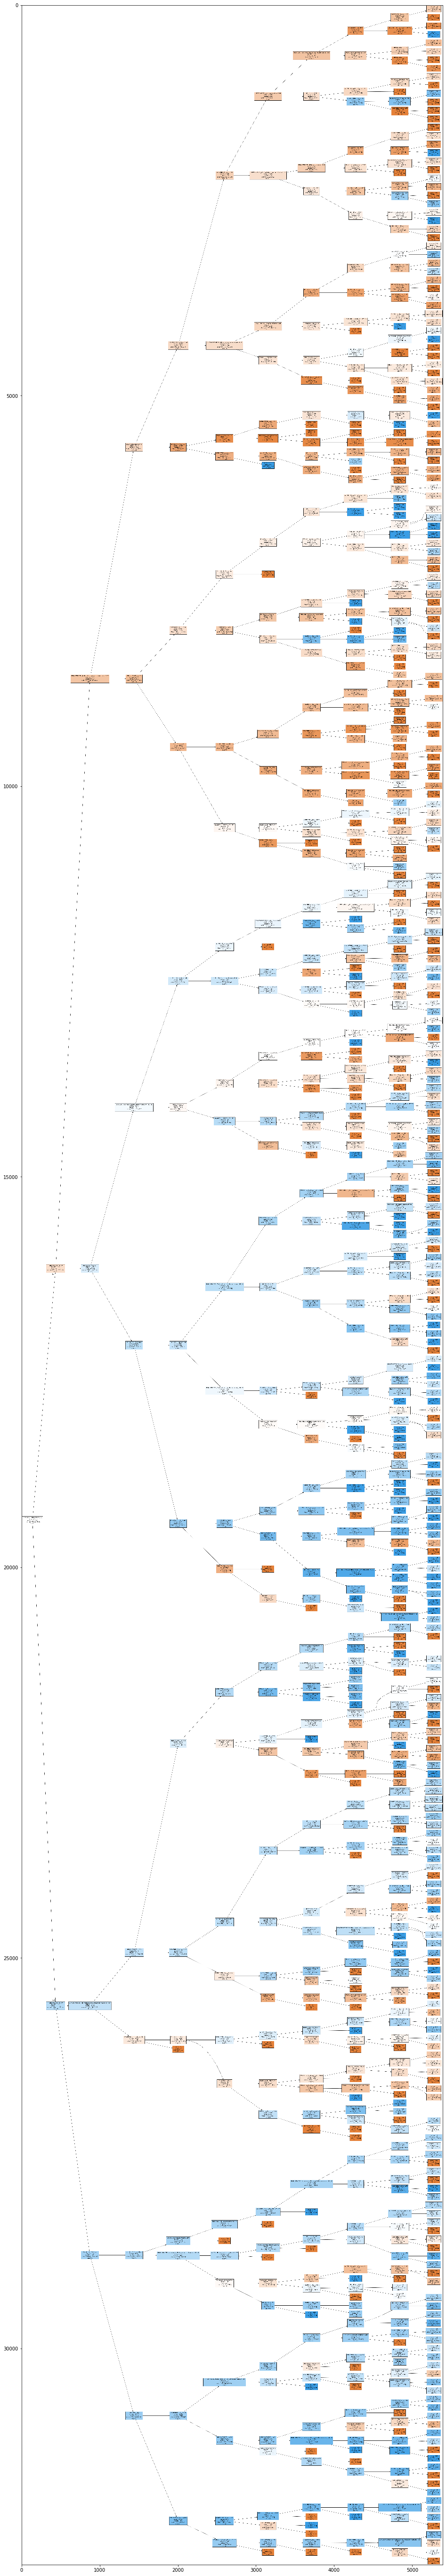

In [97]:
from io import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
import matplotlib.pyplot as plt
%matplotlib inline 
dot_data = StringIO()
filename = "image.png"
featureNames = X_columns
targetNames = ("0", "1")
out=tree.export_graphviz(dtree,feature_names=featureNames, out_file=dot_data, class_names= targetNames, filled=True,  special_characters=True,rotate=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(200, 100))
plt.imshow(img,interpolation='nearest')

### K-Means

In [98]:
n = kmeans_scores.argmax()+n_min
kmeans = KNeighborsClassifier(n_neighbors = n, weights="distance").fit(X_train, y_train)
y_predict = kmeans.predict(X_test)
results[kmeans] = Result(
    metrics.confusion_matrix(y_test, y_predict),
    metrics.accuracy_score(y_test, y_predict),
    metrics.f1_score(y_test, y_predict, average='weighted')
    )
print(metrics.classification_report(y_test, y_predict))
print(metrics.classification_report(y_train, kmeans.predict(X_train)))

              precision    recall  f1-score   support

           0       0.70      0.90      0.78     21854
           1       0.45      0.18      0.26     10411

    accuracy                           0.66     32265
   macro avg       0.57      0.54      0.52     32265
weighted avg       0.62      0.66      0.61     32265

              precision    recall  f1-score   support

           0       0.70      0.90      0.79     87200
           1       0.50      0.20      0.28     41856

    accuracy                           0.67    129056
   macro avg       0.60      0.55      0.54    129056
weighted avg       0.63      0.67      0.62    129056



### Logistic Regression
with "balaced" weight its results is really promising

In [135]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
lr = LogisticRegression(class_weight="balanced").fit(X_train, y_train)
y_predict = lr.predict(X_test)
results[lr] = Result(
    metrics.confusion_matrix(y_test, y_predict),
    metrics.accuracy_score(y_test, y_predict),
    metrics.f1_score(y_test, y_predict, average='weighted'),
    metrics.log_loss(y_test, lr.predict_proba(X_test))
    )
print(metrics.classification_report(y_test, y_predict))
print(metrics.classification_report(y_train, lr.predict(X_train)))

              precision    recall  f1-score   support

           0       0.77      0.63      0.69     21854
           1       0.43      0.60      0.50     10411

    accuracy                           0.62     32265
   macro avg       0.60      0.61      0.60     32265
weighted avg       0.66      0.62      0.63     32265

              precision    recall  f1-score   support

           0       0.77      0.63      0.69     87200
           1       0.44      0.60      0.51     41856

    accuracy                           0.62    129056
   macro avg       0.60      0.62      0.60    129056
weighted avg       0.66      0.62      0.63    129056



### SVM
This one shows good results, but it's slow

In [100]:
kernel=kernels[svm_scores.argmax()]
print(f"kernel={kernel}")
svc = svm.SVC(kernel=kernel, gamma="auto", class_weight="balanced").fit(X_train, y_train)
y_predict = svc.predict(X_test)
results[svc] = Result(
    metrics.confusion_matrix(y_test, y_predict),
    metrics.accuracy_score(y_test, y_predict),
    metrics.f1_score(y_test, y_predict, average='weighted')
    )
print(metrics.classification_report(y_test, y_predict))
print(metrics.classification_report(y_train, svc.predict(X_train)))

kernel=rbf
              precision    recall  f1-score   support

           0       0.77      0.61      0.68     21854
           1       0.43      0.62      0.51     10411

    accuracy                           0.61     32265
   macro avg       0.60      0.61      0.59     32265
weighted avg       0.66      0.61      0.62     32265

              precision    recall  f1-score   support

           0       0.77      0.61      0.68     87200
           1       0.44      0.62      0.51     41856

    accuracy                           0.62    129056
   macro avg       0.60      0.62      0.60    129056
weighted avg       0.66      0.62      0.63    129056



### Gradient Boost
This method is popular and quick, but seem to be not working in our case because its implementation in `sklearn` does not support class weights

In [226]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

depth = gbc_scores.argmax()+d_min
print(f"depth={depth}")
gbc = GradientBoostingClassifier(max_depth=depth, random_state=0).fit(X_train, y_train)
y_predict = gbc.predict(X_test)
results[gbc] = Result(
    metrics.confusion_matrix(y_test, y_predict),
    metrics.accuracy_score(y_test, y_predict),
    metrics.f1_score(y_test, y_predict, average='weighted'),
    metrics.log_loss(y_test, gbc.predict_proba(X_test))    
    )
print(metrics.classification_report(y_test, y_predict))
print(metrics.classification_report(y_train, gbc.predict(X_train)))

depth=15
              precision    recall  f1-score   support

           0       0.69      0.95      0.80     21854
           1       0.47      0.09      0.15     10411

    accuracy                           0.67     32265
   macro avg       0.58      0.52      0.47     32265
weighted avg       0.62      0.67      0.59     32265

              precision    recall  f1-score   support

           0       0.69      0.96      0.80     87200
           1       0.57      0.11      0.18     41856

    accuracy                           0.68    129056
   macro avg       0.63      0.53      0.49    129056
weighted avg       0.65      0.68      0.60    129056



### Random Forest

In [179]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

depth = rfc_scores.argmax()+d_min
print(f"depth={depth}")
rfc = RandomForestClassifier(criterion="entropy", max_depth=depth, random_state=0, class_weight="balanced").fit(X_train, y_train)
y_predict = rfc.predict(X_test)
results[rfc] = Result(
    metrics.confusion_matrix(y_test, y_predict),
    metrics.accuracy_score(y_test, y_predict),
    metrics.f1_score(y_test, y_predict, average='weighted'),
    metrics.log_loss(y_test, rfc.predict_proba(X_test))
    )
print(metrics.classification_report(y_test, y_predict))
print(metrics.classification_report(y_train, rfc.predict(X_train)))

depth=3
              precision    recall  f1-score   support

           0       0.76      0.63      0.69     21854
           1       0.43      0.59      0.50     10411

    accuracy                           0.61     32265
   macro avg       0.60      0.61      0.59     32265
weighted avg       0.65      0.61      0.63     32265

              precision    recall  f1-score   support

           0       0.76      0.63      0.69     87200
           1       0.43      0.59      0.50     41856

    accuracy                           0.62    129056
   macro avg       0.60      0.61      0.59    129056
weighted avg       0.66      0.62      0.63    129056



Trees here are not deep, so it's much easier to visualize. Unfortunately there are lot of them in the model, so we draw only one

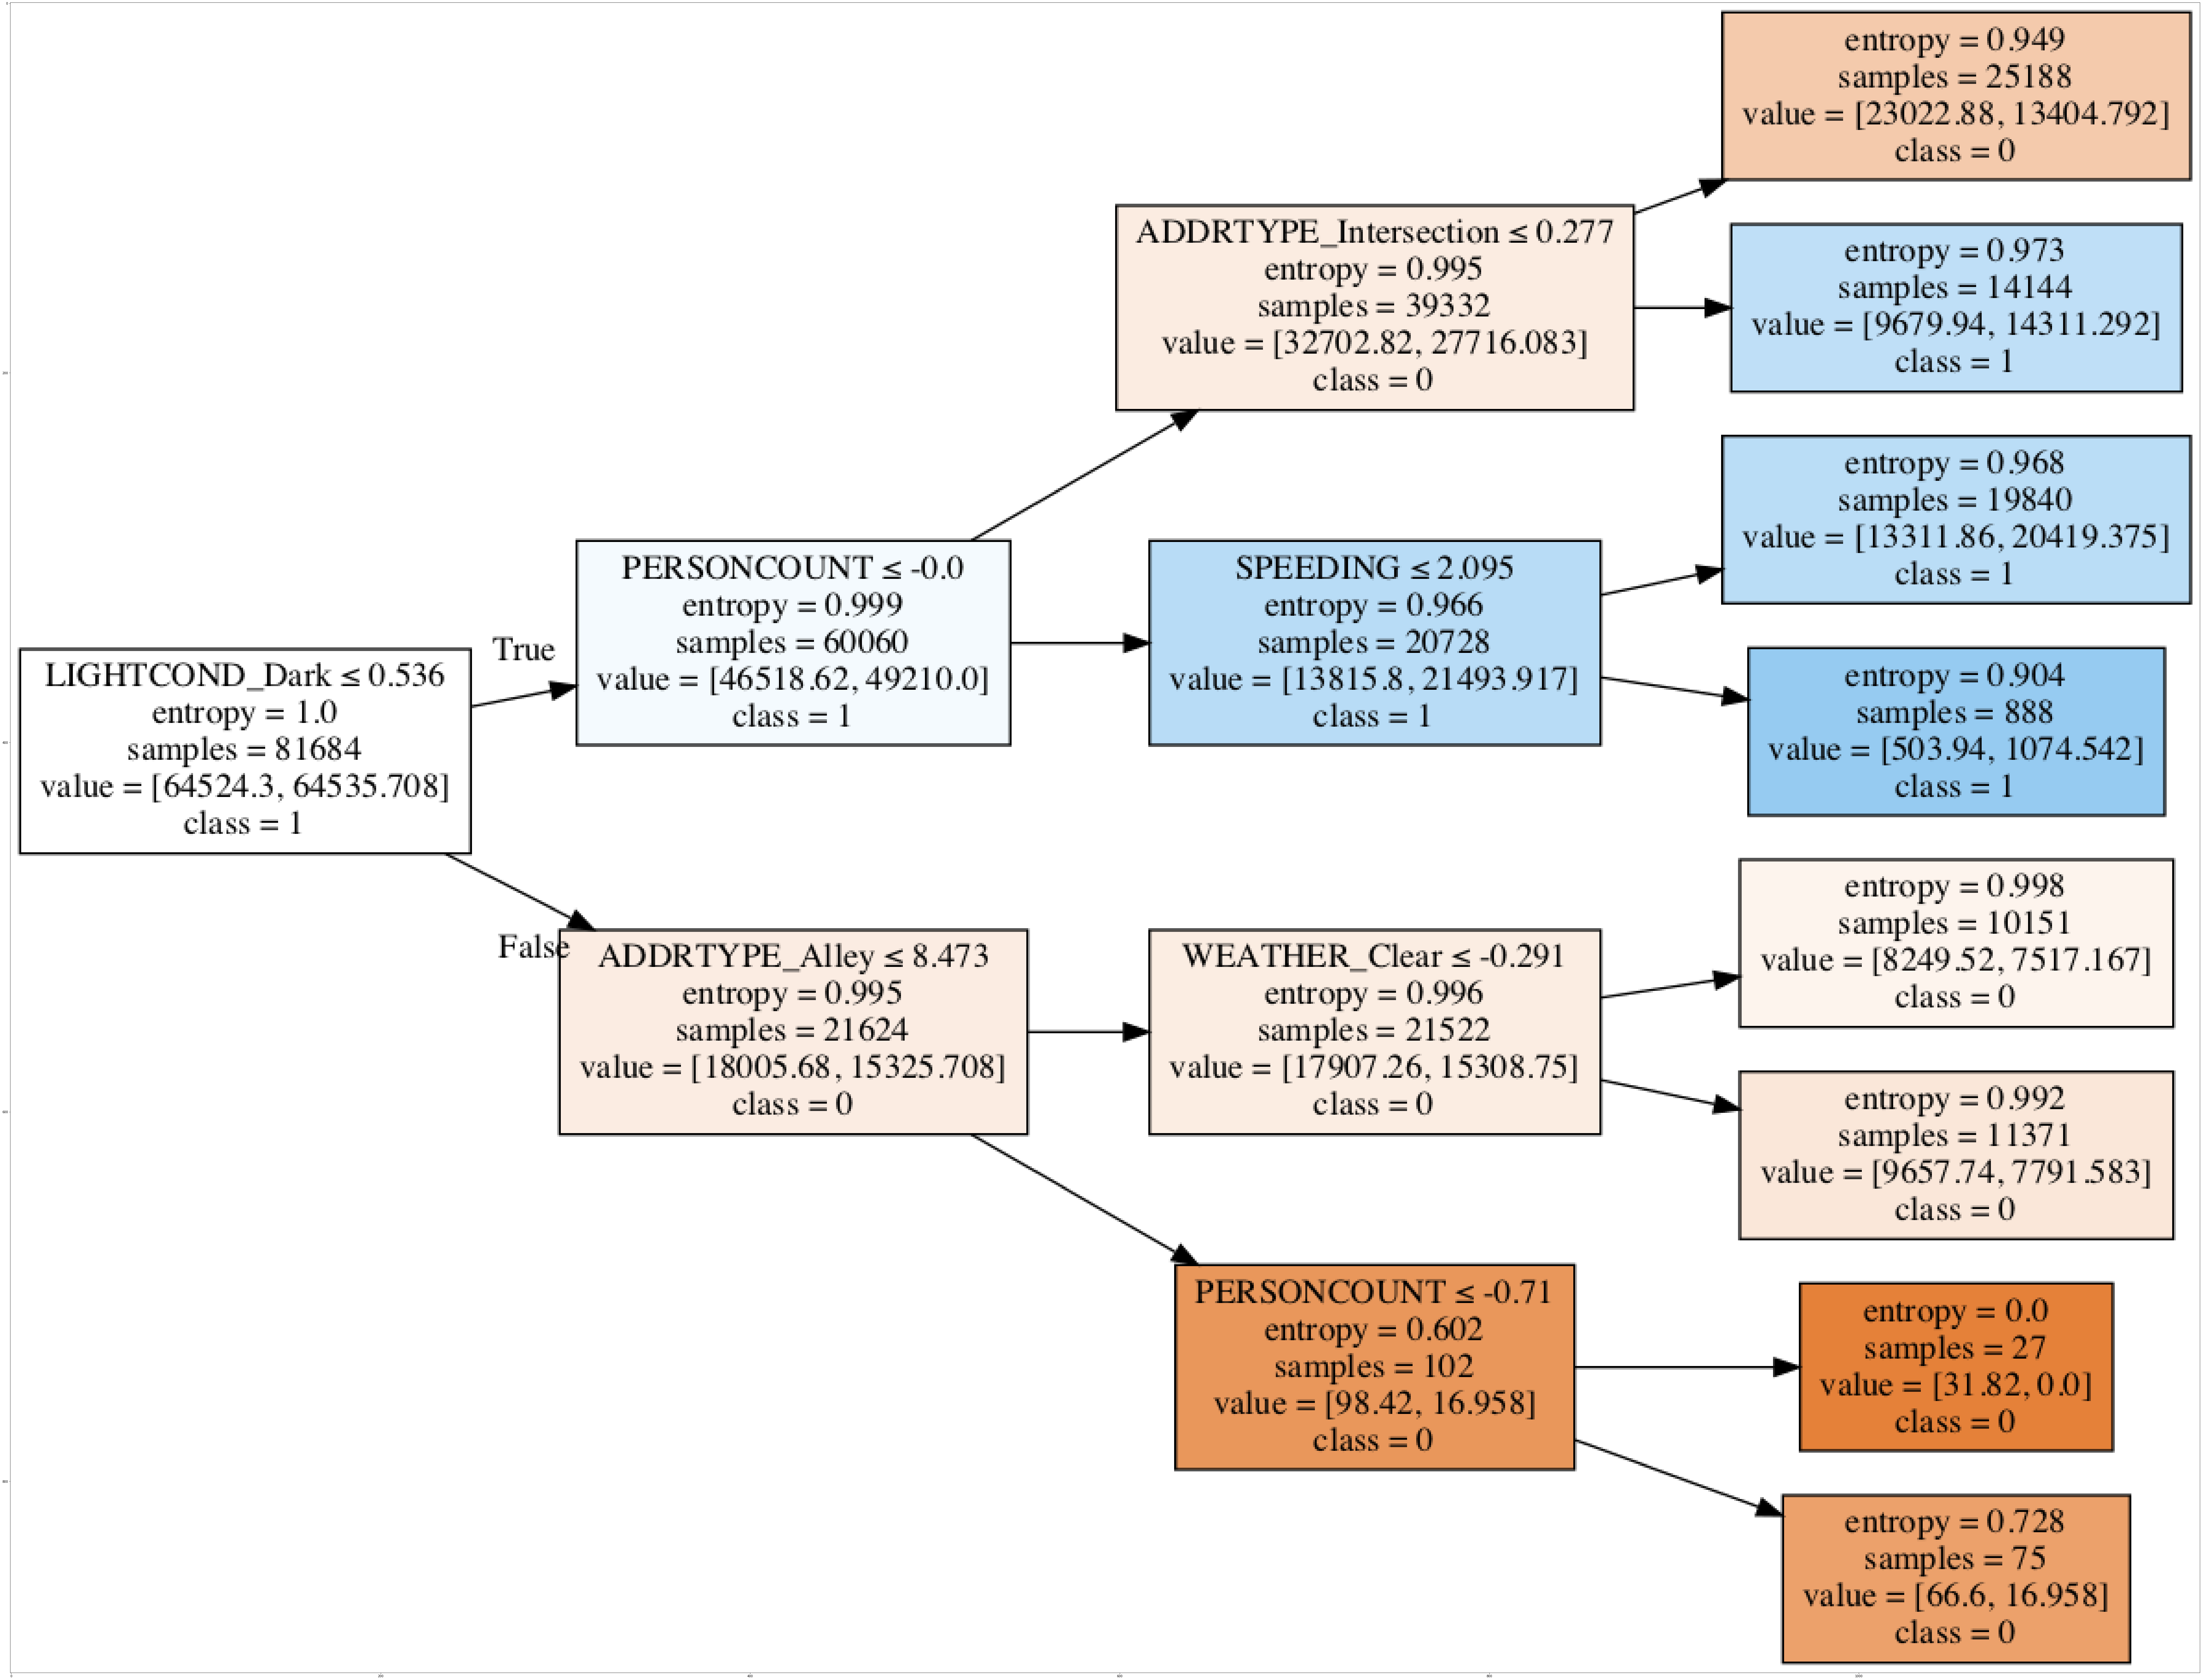

In [122]:
from io import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
import matplotlib.pyplot as plt
%matplotlib inline 
dot_data = StringIO()
filename = "image.png"
featureNames = X_columns
targetNames = ("0", "1")
out=tree.export_graphviz(rfc.estimators_[0],feature_names=featureNames, out_file=dot_data, class_names= targetNames, filled=True,  special_characters=True,rotate=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(200, 100))
plt.imshow(img,interpolation='nearest')

### Ridge Regression

In [229]:
from sklearn.linear_model import RidgeClassifier
rc = RidgeClassifier(class_weight="balanced").fit(X_train, y_train)
y_predict = rc.predict(X_test)
results[rc] = Result(
    metrics.confusion_matrix(y_test, y_predict),
    metrics.accuracy_score(y_test, y_predict),
    metrics.f1_score(y_test, y_predict, average='weighted')
    )
print(metrics.classification_report(y_test, y_predict))
print(metrics.classification_report(y_train, rc.predict(X_train)))


              precision    recall  f1-score   support

           0       0.76      0.63      0.69     21854
           1       0.43      0.59      0.50     10411

    accuracy                           0.62     32265
   macro avg       0.60      0.61      0.60     32265
weighted avg       0.66      0.62      0.63     32265

              precision    recall  f1-score   support

           0       0.76      0.64      0.69     87200
           1       0.44      0.59      0.50     41856

    accuracy                           0.62    129056
   macro avg       0.60      0.61      0.60    129056
weighted avg       0.66      0.62      0.63    129056



### Results
Now we have all the models and scores saved in the `results` dictionary, so it's easy to compare them and draw confusion matricies.

In [227]:
res = {}
for model, result in results.items():
    name = model.__class__.__name__
    res[name] = result.__dict__
pd.DataFrame.from_dict(res).transpose().drop("confusion", axis=1)


,accuracy,f1,logloss
DecisionTreeClassifier,0.610693,0.623287,0.704222
KNeighborsClassifier,0.664466,0.613634,None
LogisticRegression,0.618131,0.629733,0.662557
SVC,0.612676,0.624919,None
GradientBoostingClassifier,0.674105,0.588722,0.627829
RandomForestClassifier,0.614567,0.626017,0.667945
RidgeClassifier,0.618999,0.630189,None


Confusion matrix visualisation function

In [218]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues, axes=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    if axes is None:
        fig, ax = plt.subplots()
    else:
        ax = axes
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
#     ax.colorbar()
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

#     ax.tight_layout()
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    return fig

#### Confusion Matricies

DecisionTreeClassifier
Confusion matrix, without normalization
[[13006  8848]
 [ 3713  6698]]
KNeighborsClassifier
Confusion matrix, without normalization
[[19561  2293]
 [ 8533  1878]]
LogisticRegression
Confusion matrix, without normalization
[[13664  8190]
 [ 4131  6280]]
SVC
Confusion matrix, without normalization
[[13320  8534]
 [ 3963  6448]]
GradientBoostingClassifier
Confusion matrix, without normalization
[[20834  1020]
 [ 9495   916]]
RandomForestClassifier
Confusion matrix, without normalization
[[13714  8140]
 [ 4296  6115]]
RidgeClassifier
Confusion matrix, without normalization
[[13834  8020]
 [ 4273  6138]]


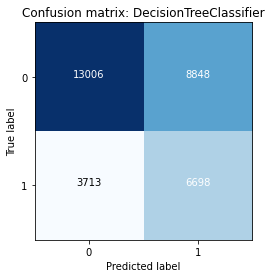

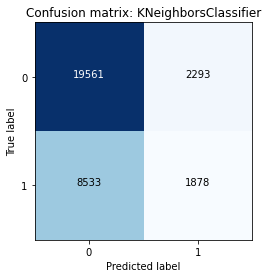

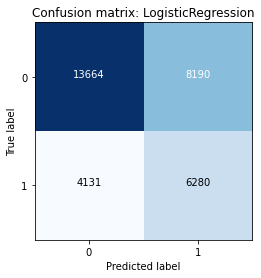

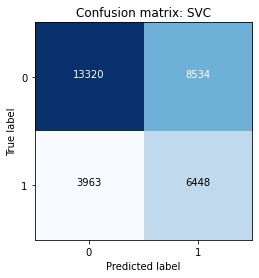

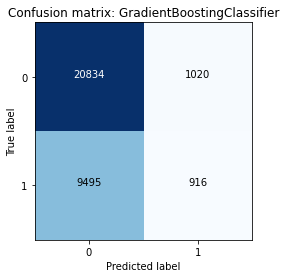

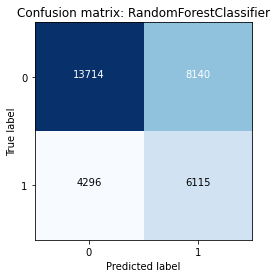

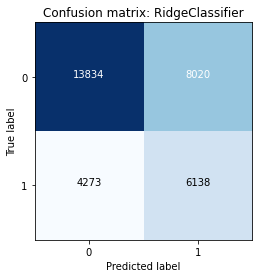

In [228]:
import itertools
for model, result in res.items():
    print(model)
#     plt.figure()
    figure = plot_confusion_matrix(result["confusion"], classes=['severe=0','severe=1'], normalize= False, title=f'Confusion matrix: {model}')
    figure.savefig(f"confmatrix_{model}.png")

With the exception of GradientBoostingClassifier results look pretty similar.
Looking at f1 score our leader is RidgeClassifier, its confusion matrix looks good, it trains quickly on full set of data and the only disadvantage is absence of prediction probability.
So for use case where probabilities are not required it is a good choice.

The alternative for the same use case could be SVC, its confusion matrix shows even less wrong predictions of false severe accidents, but f1 score is lower and it takes much more computation time to train the model.

When we really need prediction probabilities, other models should be taken. 
Here we have a choice between LogisticRegression, RandomForestClassifier and DecisionTreeClassifier.
From f1 score perspective logistic regression is the best candidate, but it lacks results interpretation, prediction probability is the only thing we can get.

So if we are required to know the  path that were taken to obtain the end result, then DecisionTreeClassifier or RandomForestClassifier should be used.
Both of then is possible to visualise, both provide prediction probability, both are quick to train and both show reasonable f1 score.

Taking into account logloss score DecisionTreeClassifier becomes the leader, but due to its depth it might be harder to visualise, its visualisation image is even too big to be included into this text.


# Conclusion


As mentioned above, different models achieved comparable performance scores, so there is real choice between them and it depends mostly on future applications.
To make things simple, here is the staring point of choice:
- severity yes/no answer - RidgeClassifier with alternative of SVC
- severity probability - DecisionTreeClassifier with alternative of LogisticRegression and RandomForestClassifier